In [2]:
from google.colab import drive

drive.mount('/content/drive/',  force_remount=True)

Mounted at /content/drive/


In [5]:
!unzip /content/drive/MyDrive/dataset.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005001.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005002.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005003.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005004.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005005.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005006.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005007.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005008.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005009.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005010.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005011.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005012.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005013.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005014.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_0000

In [3]:
import os
import pandas as pd
from PIL import Image

In [6]:
data = {'img':[], 'label':[], }
path = '/content/dataset'
folder = os.listdir(path)
class_name = {'real':0, 'StyleGAN':1, 'StyleGAN2':2}

for target in folder:
  images = os.listdir(path +'/'+target)
  cnt = 0
  for image in images:
    data['img'].append(Image.open(path +'/'+target + '/' +image))
    data['label'].append(class_name[target])
    cnt += 1
    if cnt == 2000:
      break

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['img'], data['label'], test_size=0.20, random_state=42, shuffle=True)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=True)

In [9]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt

class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [10]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

normalize = Normalize(mean=means, std=stds)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import random

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
model = models.resnet101(weights='DEFAULT')
set_parameter_requires_grad(model, True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 132MB/s]


In [14]:
model_nofr = models.resnet101(weights='DEFAULT')
set_parameter_requires_grad(model_nofr, False)
num_features = model_nofr.fc.in_features
model_nofr.fc = nn.Linear(num_features, 3)

In [15]:
model_vgg = models.vgg16(weights='DEFAULT')
num_features = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = torch.nn.Linear(num_features, 3)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 60.6MB/s]


In [16]:
model = model.to('cuda')

In [17]:
model_nofr = model_nofr.to('cuda')

In [18]:
model_vgg = model_vgg.to('cuda')

In [19]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [20]:
optimizer_vgg = optim.AdamW(model_vgg.parameters(), lr=2e-5)
criterion_vgg = nn.CrossEntropyLoss()

In [21]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=10, is_inception=False):
    start = time.time()
    val_acc_history = []

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Do this if model is in training phase
            else:
                model.eval()    # Do this if model is in validation phase

            running_loss = 0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                # Parameter gradients are initialized to 0
                optimizer.zero_grad()

                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':      # Special case of inception because InceptionV3 has auxillary outputs as well.
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward pass and Optimization in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

    time_elapsed = time.time()

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history, train_loss_history, val_loss_history

In [22]:
train_set = MyDataset(X_train,y_train, transform=_train_transforms)
trainloader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = MyDataset(X_test,y_test, transform=_val_transforms)
testloader = DataLoader(test_set, batch_size=1)

val_set =  MyDataset(X_val,y_val, transform=_val_transforms)
valloader = DataLoader(val_set, batch_size=16)

In [23]:
dataloaders = {
    'train': trainloader,
    'val': valloader
}

In [21]:
model, val_acc_history, train_loss_history, val_loss_history = train_model(model, dataloaders, optimizer, criterion, 10, False)

Epoch 0/9
----------
train Loss: 1.0672 Acc: 0.4106
val Loss: 1.0638 Acc: 0.4604
Epoch 1/9
----------
train Loss: 0.9988 Acc: 0.5565
val Loss: 1.0198 Acc: 0.5021
Epoch 2/9
----------
train Loss: 0.9473 Acc: 0.6053
val Loss: 0.9961 Acc: 0.5146
Epoch 3/9
----------
train Loss: 0.9029 Acc: 0.6493
val Loss: 0.9741 Acc: 0.5104
Epoch 4/9
----------
train Loss: 0.8680 Acc: 0.6586
val Loss: 0.9351 Acc: 0.5667
Epoch 5/9
----------
train Loss: 0.8315 Acc: 0.6949
val Loss: 0.9170 Acc: 0.5687
Epoch 6/9
----------
train Loss: 0.8058 Acc: 0.7007
val Loss: 0.9176 Acc: 0.5500
Epoch 7/9
----------
train Loss: 0.7797 Acc: 0.7153
val Loss: 0.8855 Acc: 0.5938
Epoch 8/9
----------
train Loss: 0.7581 Acc: 0.7137
val Loss: 0.8886 Acc: 0.5792
Epoch 9/9
----------
train Loss: 0.7403 Acc: 0.7220
val Loss: 0.8529 Acc: 0.6062
Training complete in 28588927m 50s
Best val Acc: 0.606250


In [22]:
model_nofr, val_acc_history_2, train_loss_history_2, val_loss_history_2 = train_model(model_nofr, dataloaders, optimizer, criterion, 10, False)

Epoch 0/9
----------
train Loss: 1.1137 Acc: 0.3225
val Loss: 1.1275 Acc: 0.2542
Epoch 1/9
----------
train Loss: 1.1131 Acc: 0.3113
val Loss: 1.1246 Acc: 0.2542
Epoch 2/9
----------
train Loss: 1.1128 Acc: 0.3081
val Loss: 1.1245 Acc: 0.2708
Epoch 3/9
----------
train Loss: 1.1131 Acc: 0.3199
val Loss: 1.1308 Acc: 0.2771
Epoch 4/9
----------
train Loss: 1.1127 Acc: 0.3127
val Loss: 1.1317 Acc: 0.2708
Epoch 5/9
----------
train Loss: 1.1138 Acc: 0.3104
val Loss: 1.1247 Acc: 0.2812
Epoch 6/9
----------
train Loss: 1.1116 Acc: 0.3229
val Loss: 1.1251 Acc: 0.2687
Epoch 7/9
----------
train Loss: 1.1130 Acc: 0.3090
val Loss: 1.1230 Acc: 0.2771
Epoch 8/9
----------
train Loss: 1.1115 Acc: 0.3146
val Loss: 1.1275 Acc: 0.2646
Epoch 9/9
----------
train Loss: 1.1124 Acc: 0.3201
val Loss: 1.1243 Acc: 0.2708
Training complete in 28588942m 43s
Best val Acc: 0.281250


In [23]:
model_vgg, val_acc_history_3, train_loss_history_3, val_loss_history_3 = train_model(model_vgg, dataloaders, optimizer_vgg, criterion_vgg, 10, False)

Epoch 0/9
----------
train Loss: 0.6218 Acc: 0.6840
val Loss: 0.4026 Acc: 0.8333
Epoch 1/9
----------
train Loss: 0.3745 Acc: 0.8211
val Loss: 0.2740 Acc: 0.8792
Epoch 2/9
----------


KeyboardInterrupt: 

In [24]:
model_path = '/content/drive/MyDrive/model/vgg16_state_dict.pth'
model_vgg.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [25]:
model_path = '/content/drive/MyDrive/model/resnet101_state_dict.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
model_path = '/content/drive/MyDrive/model/resnet101_nofreeze_state_dict.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(train_loss_history, val_loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')

    # Calculate the average losses
    average_train_loss = np.mean(train_loss_history)
    average_val_loss = np.mean(val_loss_history)

    # Display average losses on the plot
    plt.axhline(y=average_train_loss, color='r', linestyle='--', label=f'Average Training Loss: {average_train_loss:.4f}')
    plt.axhline(y=average_val_loss, color='b', linestyle='--', label=f'Average Validation Loss: {average_val_loss:.4f}')

    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

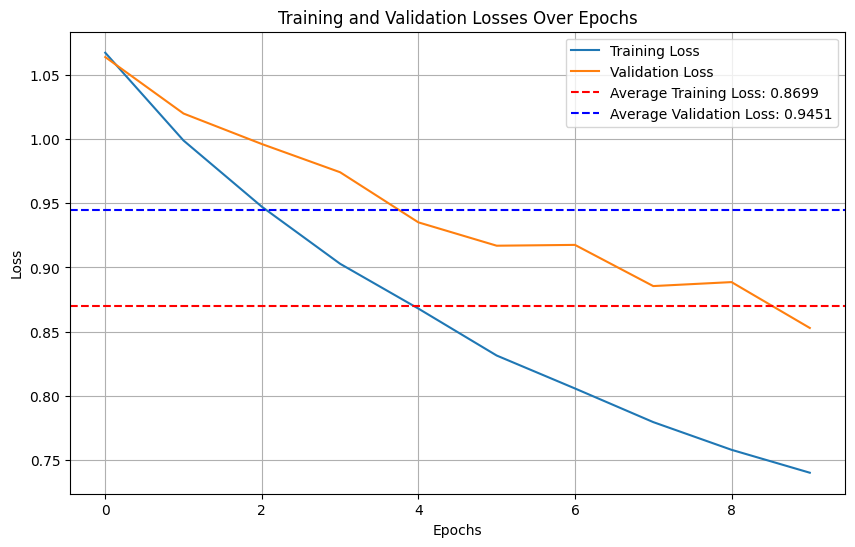

In [28]:
plot_training_history(train_loss_history, val_loss_history)

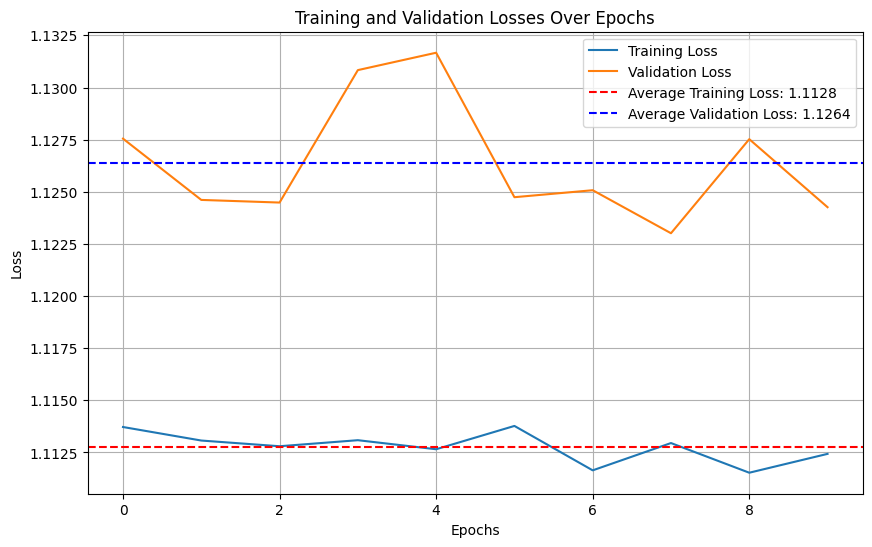

In [29]:
plot_training_history(train_loss_history_2, val_loss_history_2)

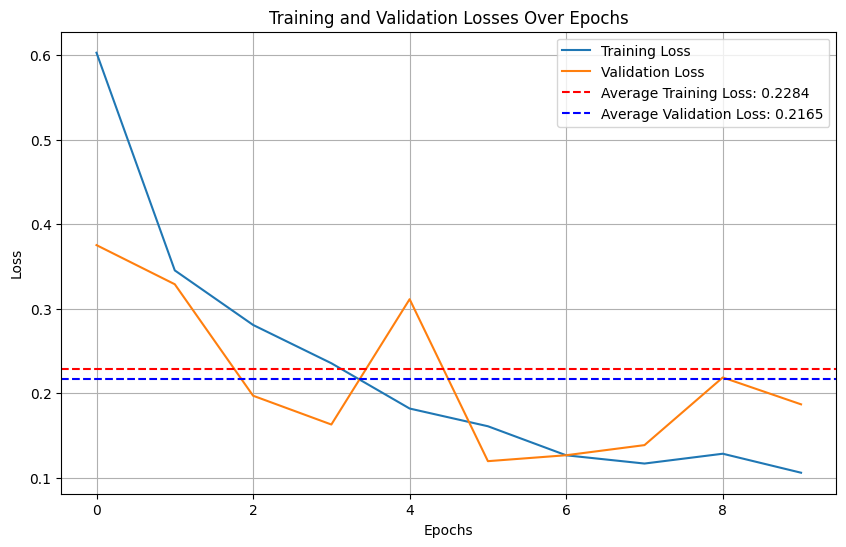

In [ ]:
plot_training_history(train_loss_history_3, val_loss_history_3)

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, dataloader, criterion, show_images=False, num_images=10):
    name_lookup = {v: k for k, v in class_name.items()}

    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    incorrect_samples = []
    incorrect_count = 0


    # No need to track gradients for testing
    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Collect incorrect samples
            misclassified_indices = (preds != labels).nonzero().flatten()
            incorrect_count += len(misclassified_indices)
            for index in misclassified_indices:
                incorrect_samples.append((inputs[index], labels[index].item(), preds[index].item()))

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Test Loss: {total_loss / total_samples:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Incorrectly Labeled: {incorrect_count}/{total_samples} ({incorrect_count/total_samples*100:.2f}%)')

    if show_images and incorrect_samples:
        num_columns = 5  # Set the number of columns for the grid
        num_rows = (num_images + num_columns - 1) // num_columns  # Calculate the required number of rows
        fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))  # Adjust the figure size appropriately
        for i, (img, true, pred) in enumerate(incorrect_samples[:num_images]):
            ax = axes[i // num_columns, i % num_columns]
            img = img.cpu().numpy().transpose((1, 2, 0))
            img = np.clip(img, 0, 1)
            ax.imshow(img, interpolation='nearest')
            ax.set_title(f'True: {name_lookup[true]},\nPred: {name_lookup[pred]}')
            ax.axis('off')

    return total_loss / total_samples, precision, recall, f1, all_labels, all_preds

In [32]:
import seaborn as sns
from sklearn.metrics import classification_report

def plot_confusion_matrix(true_labels, predictions, class_names=None):

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    print(classification_report(true_labels, predictions))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=True,  # 'd' for decimal format
                xticklabels=class_names if class_names else np.unique(true_labels),
                yticklabels=class_names if class_names else np.unique(true_labels))

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 0.8518
Precision: 0.6757, Recall: 0.6219, F1 Score: 0.5887
Incorrectly Labeled: 470/1200 (39.17%)


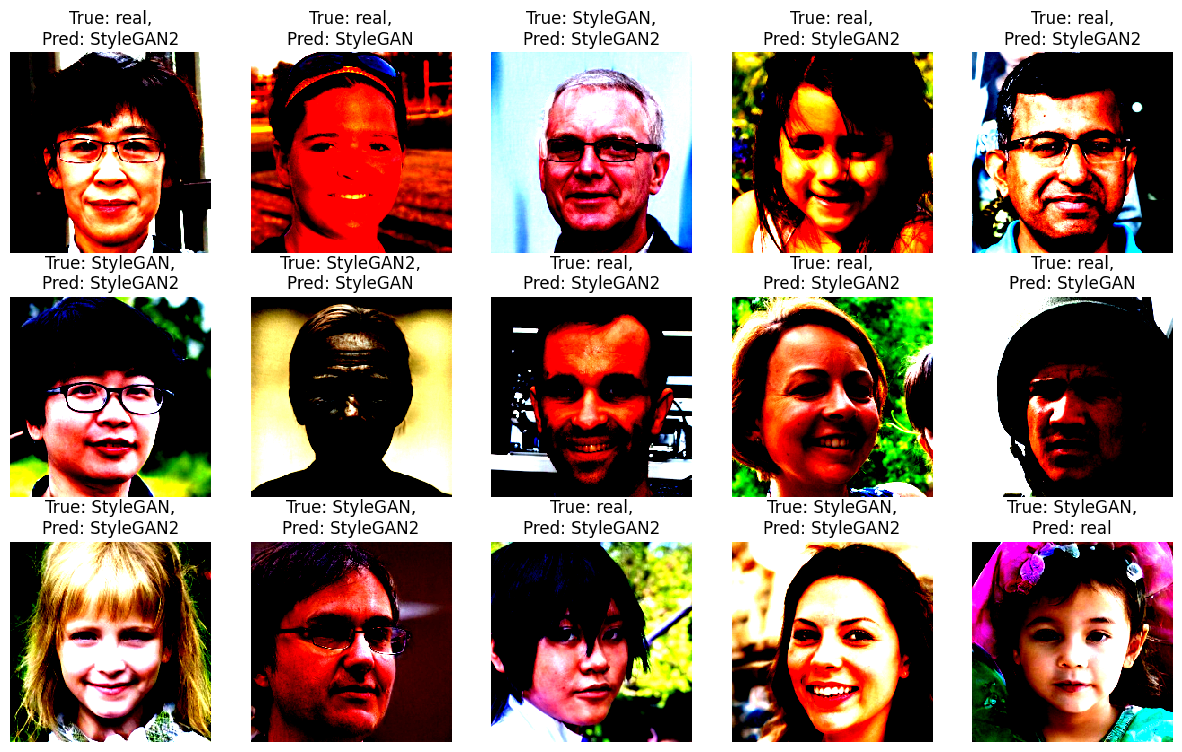

In [33]:
test_loss, test_precision, test_recall, test_f1, true_labels_res, predictions_res = test_model(model, testloader, criterion, show_images=True, num_images=15)

              precision    recall  f1-score   support

           0       0.83      0.34      0.48       437
           1       0.67      0.54      0.60       383
           2       0.53      0.99      0.69       380

    accuracy                           0.61      1200
   macro avg       0.68      0.62      0.59      1200
weighted avg       0.68      0.61      0.58      1200



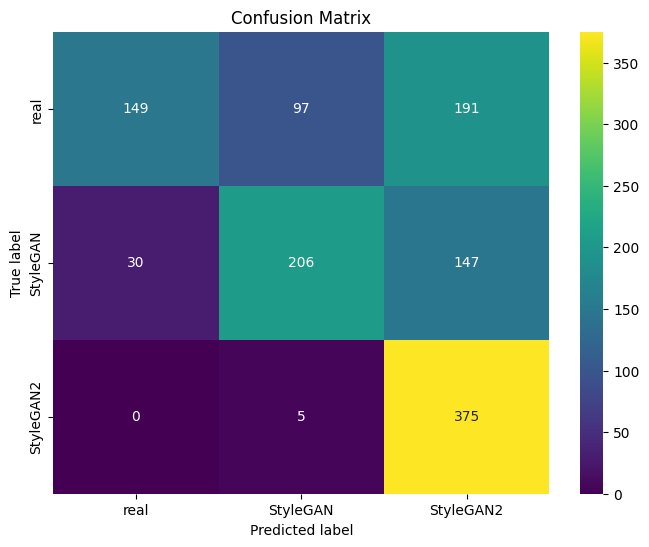

In [34]:
plot_confusion_matrix(true_labels_res, predictions_res, class_names=['real', 'StyleGAN', 'StyleGAN2'])

Test Loss: 1.1297
Precision: 0.2408, Recall: 0.2482, F1 Score: 0.2379
Incorrectly Labeled: 905/1200 (75.42%)


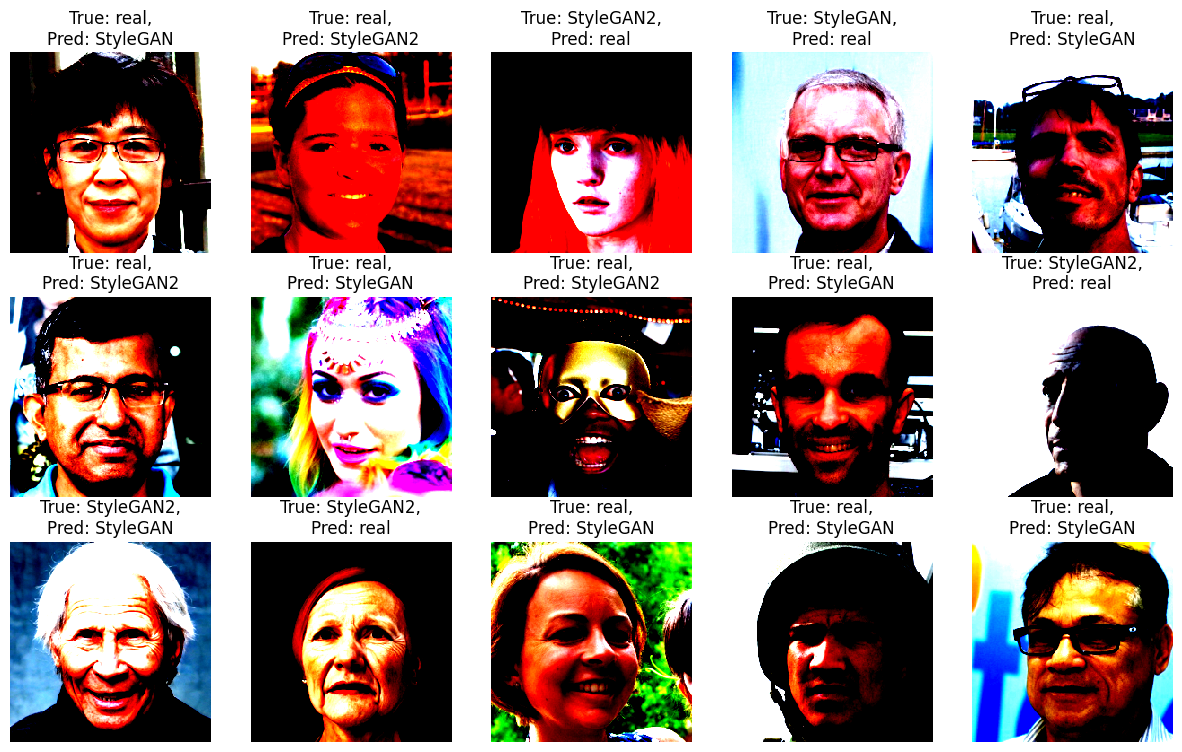

In [35]:
test_loss, test_precision, test_recall, test_f1, true_labels_nofr, predictions_nofr = test_model(model_nofr, testloader, criterion, show_images=True, num_images=15)

              precision    recall  f1-score   support

           0       0.27      0.19      0.22       437
           1       0.27      0.39      0.32       383
           2       0.19      0.16      0.17       380

    accuracy                           0.25      1200
   macro avg       0.24      0.25      0.24      1200
weighted avg       0.24      0.25      0.24      1200



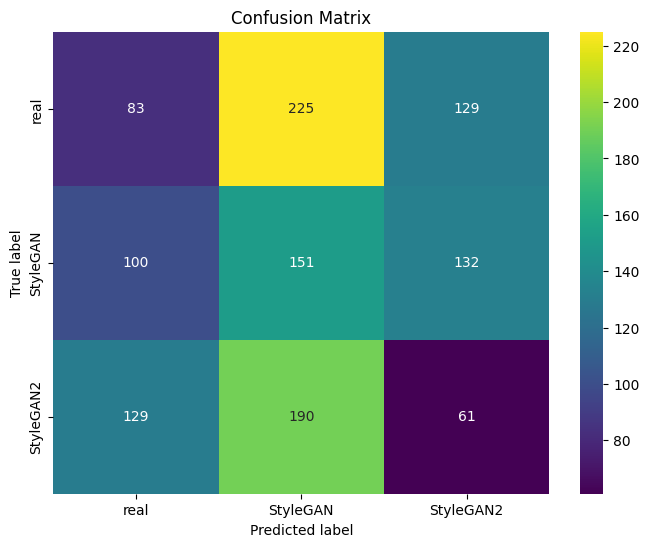

In [36]:
plot_confusion_matrix(true_labels_nofr, predictions_nofr, class_names=['real', 'StyleGAN', 'StyleGAN2'])

Test Loss: 0.1075
Precision: 0.9564, Recall: 0.9579, F1 Score: 0.9568
Incorrectly Labeled: 53/1200 (4.42%)


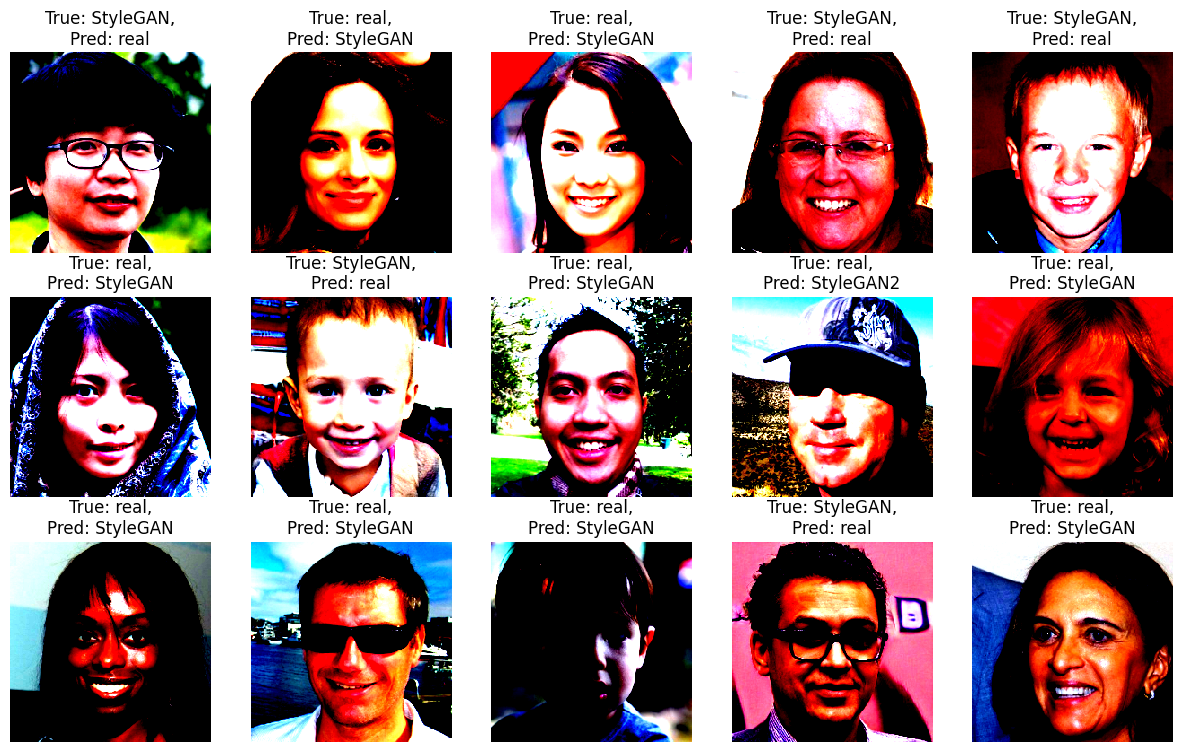

In [37]:
test_loss, test_precision, test_recall, test_f1, true_labels_vgg, predictions_vgg = test_model(model_vgg, testloader, criterion, show_images=True, num_images=15)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       437
           1       0.91      0.96      0.94       383
           2       0.99      1.00      1.00       380

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



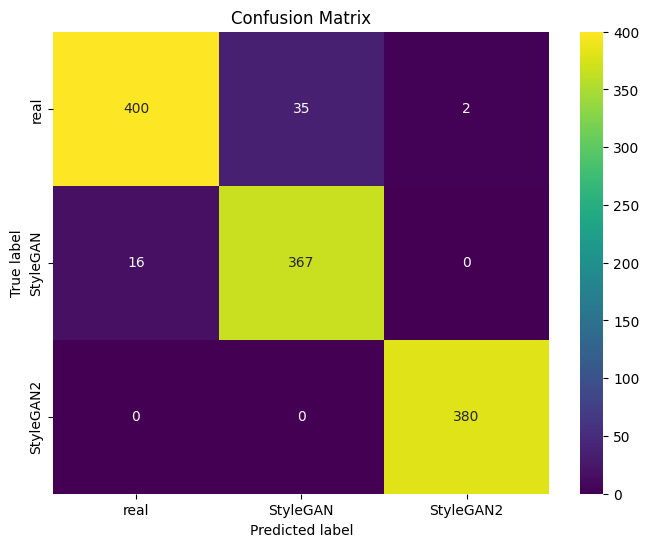

In [38]:
plot_confusion_matrix(true_labels_vgg, predictions_vgg, class_names=['real', 'StyleGAN', 'StyleGAN2'])

In [27]:
def predict_image(model, image_path, true_label):
  model.eval()
  image = Image.open(image_path)
  X_test = [image]
  y_test = [true_label]
  test_set = MyDataset(X_test,y_test, transform=_val_transforms)
  testloader = DataLoader(test_set, batch_size=1)
  with torch.no_grad():
    for inputs, labels in testloader:
      inputs = inputs.to('cuda')
      labels = labels.to('cuda')
      logits = model(inputs)
      _, preds = torch.max(logits, 1)
      if preds == 2:
        preds = 1

  return preds

In [28]:
path = "/content/drive/MyDrive/ai and human faces/"
folder = os.listdir(path)

In [29]:
def test_model_ext(model):

  num_images = len(folder)
  num_cols = 3
  num_rows = (num_images // num_cols) + (num_images % num_cols)
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

  true_labels_faces = []
  predictions_faces = []

  for i, ax in enumerate(axes.flat):
      if i < num_images:
          image_path = os.path.join(path, folder[i])
          true_label = 0 if 'human' in folder[i] else 1
          prediction = predict_image(model, image_path, true_label)

          true_labels_faces.append(true_label)
          predictions_faces.append(prediction)

          # Load and display image
          image = Image.open(image_path)
          ax.imshow(image)
          ax.axis('off')

          ax.set_title(f"True Label: {'real' if true_label == 0 else 'AI'}\nPredicted Label: {'real' if prediction == 0 else 'AI'}")

  def calculate_accuracy(labels, predictions):
      correct = sum(1 for true, pred in zip(labels, predictions) if true == pred)
      total = len(labels)
      accuracy = correct / total
      print(f"Accuracy: {correct}/{total} = {accuracy * 100:.2f}%")

  calculate_accuracy(true_labels_faces, predictions_faces)

  plt.show()

In [30]:
test_model_ext(model)

Output hidden; open in https://colab.research.google.com to view.

In [31]:
test_model_ext(model_nofr)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
test_model_ext(model_vgg)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os.path

# os.mkdir('/content/drive/MyDrive/model')
save_path = '/content/drive/MyDrive/model/vgg16_state_dict.pth'
torch.save(model_vgg.state_dict(), save_path)

In [25]:
save_path = '/content/drive/MyDrive/model/resnet101_state_dict.pth'
torch.save(model.state_dict(), save_path)

In [26]:
save_path = '/content/drive/MyDrive/model/resnet101_nofreeze_state_dict.pth'
torch.save(model_nofr.state_dict(), save_path)

In [ ]:
torch.save(model_vgg, '/content/drive/MyDrive/model/vgg16_full_model.pth')